In [1]:
%matplotlib inline
import numpy as np
from scipy.stats import norm
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
G = nx.read_gml("galFiltered.gml").to_undirected()
G = max(nx.connected_component_subgraphs(G), key=len)

labels = nx.get_node_attributes(G, "label")

genes_in_network = labels.values()

expression_data = pd.read_csv("galExpData.csv")

genes_in_expression_data = expression_data.loc[:,["GENE"]].as_matrix().flatten()

genes_in_network = [gene for gene in genes_in_network if gene in genes_in_expression_data]

# subnetwork that is labelled
nodes_of_interest = [k for k, v in nx.get_node_attributes(G, "label").items() if v in genes_in_network]
G = G.subgraph(nodes_of_interest)

p_values = expression_data.set_index("GENE").loc[genes_in_network,["gal1RGsig", "gal4RGsig", "gal80Rsig"]].as_matrix()

In [3]:
from scipy.sparse import csr_matrix

In [4]:
expr = expression_data.set_index("GENE").loc[genes_in_network,["gal1RGexp", "gal4RGexp", "gal80Rexp"]].as_matrix()

z_scores = norm.ppf(1 - p_values)

eps = 1e-8
z_scores -= (z_scores.min(axis=0) + eps)

z_scores = z_scores[:, 0, None]
z_scores = csr_matrix(z_scores)
# Z = z_scores.dot(z_scores.transpose())

A = nx.adjacency_matrix(G)

AZ = A.multiply(z_scores)

In [5]:
from scipy.sparse import identity
from scipy.sparse import diags

N = nx.number_of_nodes(G)

# A = np.array(nx.adjacency_matrix(G).todense())
DZ = np.array(AZ.sum(axis=0)).flatten()

In [6]:
# lazy random walk
W = (identity(n=N) + AZ.dot(diags(1./DZ))) / 2
# W = AZ.dot(np.diag(1./DZ))

def matrix_multiply(M, n):
    if n == 0:
        return identity(M.shape[0])
    if n % 2 == 0:
        m = matrix_multiply(M, n/2).dot(matrix_multiply(M, n/2))
    else: 
        m = M.dot(matrix_multiply(M, n-1))
    return m

In [7]:
I = np.identity(N)

n = 5

targets = matrix_multiply(W, n=n)
# targets = compute_flow(W, n=n, p0=I)

# targets -= np.diag(targets.diagonal())
# targets /= targets.sum(axis=0)

D_n = targets.sum(axis=1)

In [8]:
targets[targets < 0] = 0

In [9]:
targets

<247x247 sparse matrix of type '<type 'numpy.float64'>'
	with 11919 stored elements in Compressed Sparse Row format>

In [10]:
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Lambda, BatchNormalization
from keras.regularizers import l2

import keras.backend as K

Using TensorFlow backend.


In [11]:
# contruct model to determine angular coordinates from one hot representation of node
dropout = 0.1
num_hidden = [32]

x = Input(shape=(N,))
y = BatchNormalization()(x)
y = Dropout(dropout)(y)

for h in num_hidden:
    y = Dense(h, activation="relu")(x)
    y = BatchNormalization()(y)
    y = Dropout(dropout)(y)
    
theta = Dense(1, activation="linear")(y)

angular_embedder = Model(x, theta)

In [12]:
m = Model(x, theta)

In [13]:
m.predict(I.todense())

array([[ -5.84462844e-02],
       [ -2.89130211e-02],
       [ -8.75254273e-02],
       [ -1.11958727e-01],
       [ -9.93737578e-03],
       [  4.57051732e-02],
       [ -4.92177270e-02],
       [ -5.64437434e-02],
       [ -4.14167754e-02],
       [ -4.20028009e-02],
       [  6.34594113e-02],
       [ -1.63181379e-01],
       [  1.73969626e-01],
       [  4.10404289e-03],
       [ -3.93788293e-02],
       [  8.55961889e-02],
       [ -2.37916559e-02],
       [  2.90801022e-02],
       [ -5.58296815e-02],
       [  3.24968845e-02],
       [ -7.62060583e-02],
       [ -7.40346611e-02],
       [ -6.24395236e-02],
       [  1.29454564e-02],
       [ -1.61237761e-01],
       [  6.37445301e-02],
       [ -8.45743269e-02],
       [  9.24354568e-02],
       [  5.52903265e-02],
       [ -1.21394530e-01],
       [  5.98792285e-02],
       [ -3.94322537e-02],
       [  1.33079765e-02],
       [  1.82075575e-02],
       [ -6.74427450e-02],
       [  2.09953543e-02],
       [ -1.18845329e-01],
 

In [72]:
def angular_distance(args):
    
    theta1, theta2 = args
    
    return K.abs(theta1 - theta2)

def compute_probability(args):
    
    return K.sigmoid(args + K.constant(np.pi) / 2)

In [73]:
x1 = Input(shape=(N,))
x2 = Input(shape=(N,))

theta1 = angular_embedder(x1)
theta2 = angular_embedder(x2)

angular_differences = Lambda(angular_distance, output_shape=(1,))([theta1, theta2])
probabilities = Lambda(compute_probability, output_shape=(1,))(angular_differences)

probability_model = Model([x1, x2], probabilities)
probability_model.compile(loss="binary_crossentropy", optimizer="adam")

In [74]:
from keras_tqdm import TQDMNotebookCallback

tqdm = TQDMNotebookCallback(leave_outer=True, leave_inner=False)

from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(min_delta=0, monitor="loss", patience=100)

In [75]:
from scipy.sparse import find
def random_pos_neg_generator(batch_size, neg_bias=0.8, eps=1e-8):
    
    while True:
        
        nodes = np.random.choice(N, size=batch_size, replace=True)
     
        targs = np.random.choice(2, p=[neg_bias, 1-neg_bias], size=batch_size)
        
        nodes2 = np.array([np.random.choice(N, p=targets[:,nodes[i]].toarray().flatten()) if targs[i] == 1 else
                          np.random.choice(find(targets[:,nodes[i]] < eps)[0]) for i in range(batch_size)])
        
        in1 = np.zeros((batch_size, N))
        in1[np.arange(batch_size), nodes] = 1
        
        in2 = np.zeros((batch_size, N))
        in2[np.arange(batch_size), nodes2] = 1
        
        yield [in1, in2], targs

In [76]:
gen = random_pos_neg_generator(batch_size=100)

In [78]:
[in1, in2], t = gen.next()

In [81]:
in1.argmax(axis=1)

array([110,  98,  26, 103, 246,  57,  94, 133,  37,  95,  22,  20, 211,
       202, 130, 215, 217, 202, 114, 224,  53,  83, 170,  90, 182, 143,
       121, 181,  19, 193, 151, 137, 198,  95, 192, 152,  72, 126,  43,
       228,  40,   5, 147, 116,  42,  89, 144, 104, 103, 186, 144, 149,
        30,  75, 106,  23, 165,  22,  54, 170,  40, 191,   6, 229, 141,
       127, 126, 113,  68, 234, 147, 186, 106, 104,  36, 216,  27, 128,
       232, 116, 170, 107, 245,  44,  76, 155,  81, 218, 139, 149, 215,
         2, 217, 191,  39, 156, 104,  92,  43,  17])

In [82]:
probability_model.fit_generator(gen, steps_per_epoch=100, epochs=1000, verbose=0, 
                                callbacks=[early_stopping, tqdm])

KeyboardInterrupt: 

In [87]:
csr_matrix(I)

<247x247 sparse matrix of type '<type 'numpy.float64'>'
	with 247 stored elements in Compressed Sparse Row format>

In [89]:
thetas = angular_embedder.predict(I.todense())

In [101]:
D_n = np.array(D_n).flatten()

In [102]:
degree_sort = D_n.argsort()[::-1]

In [104]:
ranked_nodes = np.array([np.where(degree_sort==x)[0][0] for x in range(N)])

In [105]:
import powerlaw

result = powerlaw.Fit(D_n)

gamma = result.alpha

beta = 1. / (gamma - 1)

beta

R = 2 * beta * np.log(range(1, N + 1)) + 2 * (1 - beta) * np.log(N) 
R = R[ranked_nodes]

Calculating best minimal value for power law fit
/home/david/miniconda2/lib/python2.7/site-packages/powerlaw.py:697: RuntimeWarning: invalid value encountered in divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


In [106]:
R

array([ 10.83200346,   9.45141246,  10.93644578,  10.05048291,
         8.47485761,   9.97838625,  10.70432542,  10.92700721,
         9.00394014,  10.69992486,  10.92064172,   9.05465114,
        10.2558401 ,   9.71968113,   9.5529741 ,  10.57956545,
        10.987603  ,  10.59001275,   9.9525611 ,   9.86866612,
        11.00194914,   9.82251704,  10.7790489 ,   9.77302907,
         7.72309329,   9.73792982,  10.44633124,  10.45269673,
        10.51906712,   9.70093241,  10.9426666 ,  10.95189306,
         9.39435564,  10.9549411 ,  10.40003342,  10.96998095,
        10.96099677,  10.72165003,  10.48366516,  10.84641   ,
        10.79074637,  10.42026007,  10.01538366,   9.18750926,
        10.56895616,   9.47825062,  10.07292051,  10.67748726,
         9.57617243,  10.75909747,  10.10525497,  10.5951772 ,
        10.84996474,  10.93956326,  10.66366284,   8.75231145,
        11.01041463,  10.7259135 ,  10.8777568 ,  10.37919063,
        10.80980848,   9.33210499,  10.74684129,  10.66

In [113]:
X = np.column_stack([R[:,None] * np.cos(thetas), R[:,None] * np.sin(thetas)]) 

In [114]:
c = ["k"] * N

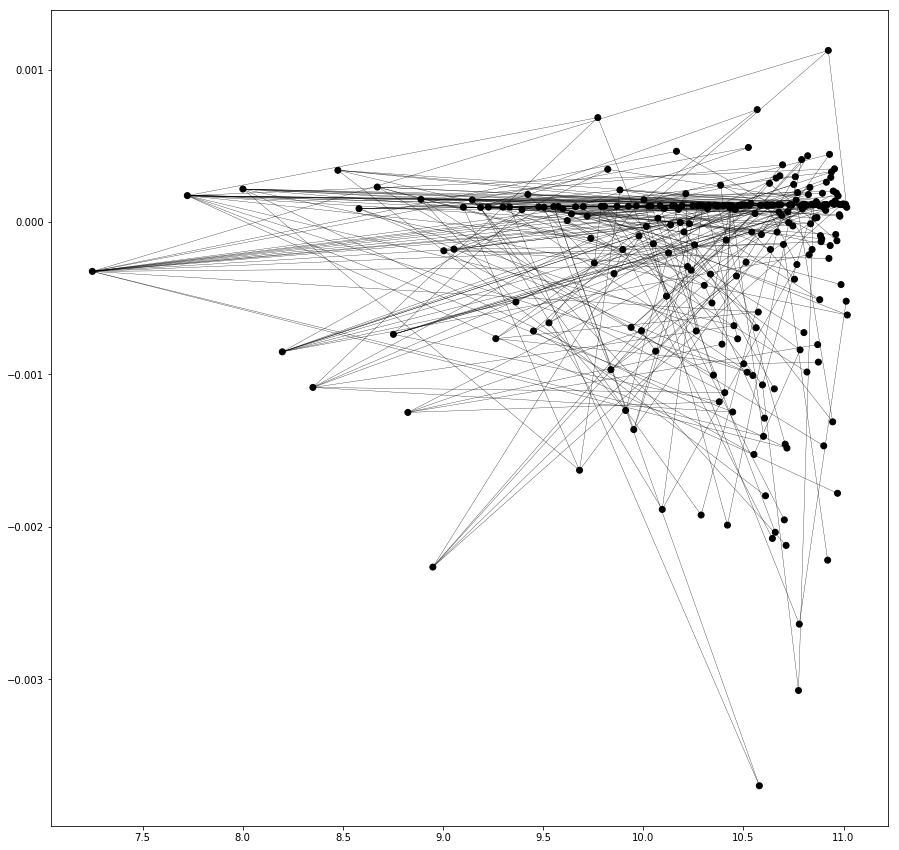

In [119]:
plt.figure(figsize=(15, 15))
l = 15
# for label, i, j in zip(z_values, X[:l, 0], X[:l, 1]):
#     plt.annotate(
#         label,
#         xy=(i, j), xytext=(-20, 20),
#         textcoords='offset points', ha='right', va='bottom',
#         bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
#         arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

nodes = np.array(G.nodes())
for n1, n2 in G.edges():
    i, = np.where(nodes == n1)
    j, = np.where(nodes == n2)
    plt.plot(X[(i, j), 0], X[(i, j), 1], c="k", 
             linewidth = 0.3)

plt.scatter(X[:,0], X[:,1], c = c, )